
# **DATA COMPRESSION**




# **Deep Convolutional AutoEncoder-based Lossy Image Compression**

Link to the Research paper :
[Paper](https://ieeexplore.ieee.org/abstract/document/8456308 )

**Link to my drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import required libraries**

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt



**Denormalize**

In [ ]:
def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x


**Show image**

In [ ]:

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


**Device Selection**

In [ ]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cpu


**Reproducibility**

In [ ]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

**Data loading**

In [ ]:
batch_size = 128

if not os.path.exists('/content/drive/MyDrive/DC Package/CW/CAE'):
    os.makedirs('/content/drive/MyDrive/DC Package/CW/CAE')



NUM_TRAIN = 49000
#Converting data to torch.FloatTensor - matrix containing elements of float type and normalizing the image
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform_train)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform_test)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform_test)

#Prepare data loaders used for training and testing
loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

#Obtain one batch of training images
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), '/content/drive/MyDrive/DC Package/CW/CAE/input_sample.png')


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


##  **Convolutional Autoencoder** 

**Hyper-parameter selection**

In [ ]:

### Choose the number of epochs and the learning rate.
num_epochs = 20
learning_rate  = 0.002

**Define model**

In [ ]:

### Choose a value for the latent space dimension and use it in your model
#16x4x4 - fully convolutional AE
hidden_size = 256 

def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True, negative_slope=0.2)]

def make_transconv_bn_relu(in_channels, out_channels, kernel_size=3, stride=2, padding=0):
    return [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)]

def make_transconv_tanh_final(in_channels, out_channels, kernel_size=3, stride=2, padding=0):
    return [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.Tanh()]

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        #Downsampling part
        self.down1 = nn.Sequential(
            *make_conv_bn_relu(3, 64, kernel_size=3, stride=2, padding=1 ))
        
        self.down2 = nn.Sequential(
            *make_conv_bn_relu(64, 32, kernel_size=3, stride=2, padding=1 ))
        
        self.down3 = nn.Sequential(
            *make_conv_bn_relu(32, 16, kernel_size=3, stride=2, padding=1 ))
        
        self.up1 = nn.Sequential(
            *make_transconv_bn_relu(16, 32, kernel_size=2, stride=2))
        
        self.up2 = nn.Sequential(
            *make_transconv_bn_relu(32, 64, kernel_size=2, stride=2))
        
        self.up3 = nn.Sequential(
            *make_transconv_tanh_final(64, 3, kernel_size=2, stride=2))
        


    def encode(self, x):
        

        x = self.down1(x)
        #x = self.maxpool(x)
        #print(x.size())
        x = self.down2(x)
        #x = self.maxpool(x)
        #print(x.size())
        x = self.down3(x)
        #x = self.maxpool(x)
        #print(x.size())
        
        ### Here the image is compressed
        return x

    
    def decode(self, z):

        z=self.up1(z)
        #print(z.size())
        z=self.up2(z)
        #print(z.size())
        z=self.up3(z)
        #print(z.size())
        return z


    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon


**Define Loss function**

In [ ]:
# measuring mean square error
# other loss functions : MAE,negative log likelihood
criterion = nn.MSELoss() 

def loss_function_CAE(recon_x, x):
    recon_loss = criterion(recon_x, x)
    return recon_loss

**Initialize Model and print number of parameters**

In [ ]:
model = CAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 36192
CAE(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (up1): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

**Choose and initialize optimizer**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Train**

In [ ]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_CAE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(loader_train)))
    recon = model(fixed_input.to(device))
    recon = denorm(recon.cpu())
    save_image(recon, '/content/drive/MyDrive/DC Package/CW/CAE/reconstructed_epoch_{}.png'.format(epoch))
    train_losses.append(train_loss/ len(loader_train))

# save the model and the loss values
np.save('/content/drive/MyDrive/DC Package/CW/CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), '/content/drive/MyDrive/DC Package/CW/CAE/CAE_model2.pth')

epoch [1/20], loss:0.0600
epoch [2/20], loss:0.0254
epoch [3/20], loss:0.0210
epoch [4/20], loss:0.0189
epoch [5/20], loss:0.0175
epoch [6/20], loss:0.0168
epoch [7/20], loss:0.0164
epoch [8/20], loss:0.0159
epoch [9/20], loss:0.0157
epoch [10/20], loss:0.0153
epoch [11/20], loss:0.0152
epoch [12/20], loss:0.0151
epoch [13/20], loss:0.0151
epoch [14/20], loss:0.0147
epoch [15/20], loss:0.0148
epoch [16/20], loss:0.0147
epoch [17/20], loss:0.0145
epoch [18/20], loss:0.0145
epoch [19/20], loss:0.0144
epoch [20/20], loss:0.0144


In [ ]:
np.load('/content/drive/MyDrive/train_losses.npy')

array([0.05996024, 0.02537435, 0.02101022, 0.01887774, 0.01748713,
       0.01677063, 0.01640232, 0.0159025 , 0.01568414, 0.01530316,
       0.0152296 , 0.01514446, 0.01511746, 0.01474581, 0.01475927,
       0.01474573, 0.01449242, 0.01446305, 0.014386  , 0.01438655])

**Train loss curve**

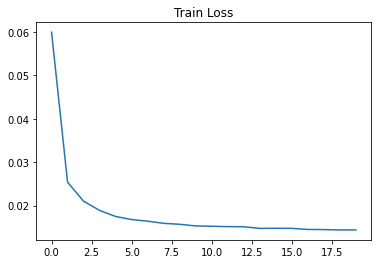

In [ ]:
train_losses = np.load('/content/drive/MyDrive/DC Package/CW/CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

**Test set reconstruction error**

In [ ]:
# load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/DC Package/CW/CAE/CAE_model2.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.5f}'.format(test_loss))

Test set loss: 0.00012


**Test set images**

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


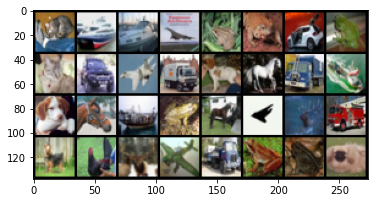

In [ ]:
# load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/DC Package/CW/CAE/CAE_model2.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)

show(img)